#### Code to validate models

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ../src

/home/theo/kaggle/siim_covid/src


## Imports

In [4]:
import os
import cv2
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import *
from collections import Counter
from tqdm.notebook import tqdm

In [5]:
from params import *

In [6]:
from data.preparation import prepare_dataframe, handle_duplicates
from data.dataset import CovidDetDataset, CovidClsDataset
from data.transforms import get_transfos_det, get_transfos_cls

from model_zoo.models import get_model

from utils.plot import plot_sample

from utils.logger import Config

from utils.metrics import per_class_average_precision_score, study_level_map

## Data

### Load

In [7]:
EXP_FOLDERS = [
    LOG_PATH + "2021-07-30/4/",
    LOG_PATH + "2021-07-31/0/",
#     LOG_PATH + "2021-08-01/0/",
    LOG_PATH + "2021-08-01/1/",
]

EXP_FOLDER = EXP_FOLDERS[-1]

USE_TTA = True

In [8]:
config = Config(json.load(open(EXP_FOLDER + "config.json", 'r')))

In [9]:
if USE_TTA:
    pred_oof_img = np.mean([np.load(f + "pred_oof_img_flip.npy") for f in EXP_FOLDERS], 0)
    pred_oof_study = np.mean([np.load(f + "pred_oof_study_flip.npy") for f in EXP_FOLDERS], 0)
else:
    pred_oof_img = np.mean([np.load(f + "pred_oof_img.npy") for f in EXP_FOLDERS], 0)
    pred_oof_study = np.mean([np.load(f + "pred_oof_study.npy") for f in EXP_FOLDERS], 0)

In [10]:
df = pd.read_csv(EXP_FOLDER + "data.csv")

pred_cols = [c + "_pred" for c in CLASSES]
df[pred_cols] = pred_oof_study
df['pred_img'] = pred_oof_img

In [11]:
ap = per_class_average_precision_score(pred_oof_img, df['img_target'].values)
print(f'Image mAP : {ap :.4f}')

auc = roc_auc_score(df['img_target'], pred_oof_img)
print(f'Image AUC : {auc :.4f}')
acc = accuracy_score(df['img_target'], pred_oof_img > 0.5)
print(f'Image Acc : {acc :.4f}')

Image mAP : 0.9618
Image AUC : 0.9118
Image Acc : 0.8464


In [12]:
study_map = study_level_map(df[pred_cols].values, df[CLASSES].values, df['study_id'].values)
print(f'Study mAP : {study_map :.4f}')

Study mAP : 0.3837


### Post-process

#### Img merging

In [13]:
groups = df[['study_id', 'pred_img']].groupby('study_id').mean().rename(
    columns={'pred_img': 'pred_img_merged'}
).reset_index()
df_ = df.merge(groups, on="study_id", how="left")

# df_.loc[df_['negative_pred'] > 0.75, 'pred_img'] = 0
# df_.loc[df_['typical_pred'] > 0.75, 'pred_img'] = 1
# df_.loc[df_['indeterminate_pred'] > 0.75, 'pred_img'] = 1

In [14]:
ap = per_class_average_precision_score(df_['pred_img_merged'].values, df['img_target'].values)
print(f'Image mAP : {ap :.4f}')
auc = roc_auc_score(df_['img_target'], df_['pred_img_merged'])
print(f'Image AUC : {auc :.4f}')
acc = accuracy_score(df_['img_target'], df_['pred_img_merged'] > 0.5)
print(f'Image Acc : {acc :.4f}')

Image mAP : 0.9618
Image AUC : 0.9120
Image Acc : 0.8467


#### Study using img

In [15]:
df_ = df.copy()

p = 0.5
df_['negative_pred'] *= (1 - df_['pred_img']) ** p
df_['typical_pred'] *= (df_['pred_img']) ** p

# df_['indeterminate_pred'] *= (df_['pred_img']) ** p
# df_['atypical_pred'] *= (df_['pred_img']) ** p

study_map = study_level_map(df_[pred_cols].values, df_[CLASSES].values, df['study_id'].values)
print(f'Study mAP : {study_map :.5f}')

Study mAP : 0.38389


In [16]:
df_study = df[
    ['study_id'] + pred_cols + CLASSES + ['img_target', 'pred_img']
].groupby('study_id').agg(np.mean).copy()

# df_study['negative_pred'] *= 1 - df_study['pred_img'] 
# df_study['typical_pred'] *= df_study['pred_img'] 
# df_study['indeterminate_pred'] *= df_study['pred_img'] 
# df_study['atypical_pred'] *= df_study['pred_img'] 

df_study.loc[df_study['pred_img'] > 0.75, 'negative_pred'] *= 0.5
df_study.loc[df_study['pred_img'] < 0.2, 'negative_pred'] *= 2

df_study.loc[df_study['pred_img'] > 0.75, 'typical_pred'] *= 1.2
# df_study.loc[df_study['pred_img'] > 0.9, 'indeterminate_pred'] *= 1.1
# df_study.loc[df_study['pred_img'] > 0.9, 'atypical_pred'] *= 1.1

df_study.loc[df_study['pred_img'] < 0.25, 'typical_pred'] *= 0.8
# df_study.loc[df_study['pred_img'] < 0.2, 'indeterminate_pred'] *= 0.9
# df_study.loc[df_study['pred_img'] < 0.2, 'atypical_pred'] *= 0.9

accs = per_class_average_precision_score(
    df_study[pred_cols].values,
    df_study[CLASSES].values, 
    num_classes=NUM_CLASSES, 
    average=False
)
np.round(accs, 4), np.round(np.mean(accs) * 2/3, 4)

(array([0.804 , 0.8483, 0.3057, 0.3446]), 0.3838)

## Results

In [17]:
def proc(x):
    x = x.split('0 0 1 1')[:4]
    x = [float(y.strip().split(' ')[1]) for y in x]
    return x

In [18]:
sub = pd.read_csv("../output/sub_0931.csv")

In [19]:
sub

,id,PredictionString
0,00188a671292_study,negative 0.8009114503860474 0 0 1 1 typical 0....
1,004bd59708be_study,negative 0.0055577514367178 0 0 1 1 typical 0....
2,00508faccd39_study,negative 0.5854789519309997 0 0 1 1 typical 0....
3,006486aa80b2_study,negative 0.2664635345339775 0 0 1 1 typical 0....
4,00655178fdfc_study,negative 0.5432932925224304 0 0 1 1 typical 0....
...,...,...
2472,46719b856de1_image,opacity 0.000103951003 1967 848 2240 1224 opac...
2473,31c07523a69a_image,opacity 0.000112533999 1336 1726 2062 2707 opa...
2474,f77d7d1aebab_image,opacity 0.000101685997 0 1049 1008 2110 opacit...
2475,ccc5b63ca96d_image,opacity 0.000101088997 2258 1818 2811 2494 opa...


In [20]:
sub = pd.read_csv("../output/sub_0931.csv")
sub_study = sub[sub['id'].apply(lambda x: "study" in x)].copy()

pred_test = np.array(sub_study['PredictionString'].apply(proc).values.tolist())

for i, c in enumerate(CLASSES):
    sub_study[c] = pred_test[:, i]
    
sub_study.to_csv("../output/sub_0931_study.csv", index=False)

In [21]:
sub = pd.read_csv("../output/sub_0931.csv")

sub_img = sub[sub['id'].apply(lambda x: "study" not in x)].copy()
sub_img['none'] = sub_img['PredictionString'].apply(lambda x: float(x.split('none')[-1].strip().split(' ')[0]))

sub_img.to_csv("../output/sub_0931_img.csv", index=False)

In [22]:
def treat_oof(pred_oof_study):
    pred_oof_study['id'] = pred_oof_study['id'].apply(lambda x: x.split('_')[0])
    
    df_study = pd.read_csv(DATA_PATH + "train_study_level.csv")
    df_study['study_id'] = df_study['id'].apply(lambda x: x.split('_')[0])
    df_study = df_study.rename(columns={c: c.split(' ')[0].lower() for c in df_study.columns})

    df_study.drop('id', axis=1, inplace=True)

    df_study = df_study.merge(pred_oof_study, how="left", left_on="study_id", right_on="id").dropna()
    
    pred_oof_study = np.array(df_study['PredictionString'].apply(proc).values.tolist())
    
    df_study[pred_cols] = pred_oof_study
    
    df_g = df[['study_id'] + pred_cols].groupby('study_id').mean().reset_index()
    df_study = df_study.merge(df_g, how="left", left_on="id", right_on="study_id", suffixes=['', '_theo'])
    
    return df_study

In [23]:
df_old = treat_oof(pd.read_csv('../output/OOF_study_only_EBV2M_768.csv'))
df_v2m_2 = treat_oof(pd.read_csv('../output/oof_v2m.csv'))
df_b4 = treat_oof(pd.read_csv('../output/oof_b4.csv'))
df_b5 = treat_oof(pd.read_csv('../output/oof_b5.csv'))
df_ono = treat_oof(pd.read_csv('../output/oof_ono.csv')[['id', 'PredictionString']])

In [24]:
df_theo = df[['study_id'] + pred_cols + CLASSES].groupby('study_id').mean().reset_index()
df_theo = df_v2m_2[['id']].merge(df_theo, how="left", left_on="id", right_on="study_id")

df_ono = df_v2m_2[['id']].merge(df_ono, how="left", left_on="id", right_on="study_id")

In [25]:
p = 1
oofs = [
#     df_old[pred_cols].values ** p * 1,
    df_theo[pred_cols].values ** p * 1,
    df_v2m_2[pred_cols].values ** p * 1,
#     df_b4[pred_cols].values ** p * 0.1,
    df_b5[pred_cols].values ** p * 0.5,
#     df_ono[pred_cols].values ** p * 0.1,
]

oof = np.mean(oofs, 0)

In [26]:
oof.max(0)

array([0.81548033, 0.82042662, 0.45061728, 0.72142012])

In [27]:
CLASSES

['negative', 'typical', 'indeterminate', 'atypical']

In [28]:
from scipy.stats import pearsonr

In [29]:
truth = df_theo[CLASSES].values
pred = oof
aucs = [roc_auc_score(truth[:, i].flatten(), pred[:, i].flatten()) for i in range(pred.shape[1])]
aucs

[0.9245791267993855,
 0.8716798196539874,
 0.6936576816806146,
 0.8088301490017489]

In [30]:
for i in range(4):
    print(pearsonr(pred[:, 2], pred[:, i])[0])

-0.31857153472497285
-0.10282744914231445
1.0
0.5120329913073178


In [31]:
per_class_average_precision_score(oof, df_theo[CLASSES].values, num_classes=NUM_CLASSES) * 2 / 3

0.3911764051701341

In [32]:
per_class_average_precision_score(oof, df_theo[CLASSES].values, num_classes=NUM_CLASSES, average=False) #* 2 / 3

array([0.8115245 , 0.85174614, 0.3177787 , 0.36600908])

## Blend img

In [33]:
oof_mk = pd.read_csv("../output/oof_image_level_mk.csv")

In [34]:
oof_mk = oof_mk.merge(df, on='image_id', how='left')[['image_id', 'img_target', 'pred_img', 'pred']].dropna()

In [35]:
ap = per_class_average_precision_score(oof_mk['pred'].values, oof_mk['img_target'].values)
print(f'Image mAP : {ap :.4f}')
auc = roc_auc_score(oof_mk['img_target'], oof_mk['pred'])
print(f'Image AUC : {auc :.4f}')
acc = accuracy_score(oof_mk['pred'] > 0.5, oof_mk['img_target'] > 0.5)
print(f'Image Acc : {acc :.4f}')

Image mAP : 0.9528
Image AUC : 0.8916
Image Acc : 0.8339


In [36]:
ap = per_class_average_precision_score(oof_mk['pred_img'].values, oof_mk['img_target'].values)
print(f'Image mAP : {ap :.4f}')
auc = roc_auc_score(oof_mk['img_target'], oof_mk['pred_img'])
print(f'Image AUC : {auc :.4f}')
acc = accuracy_score(oof_mk['pred_img'] > 0.5, oof_mk['img_target'] > 0.5)
print(f'Image Acc : {acc :.4f}')

Image mAP : 0.9617
Image AUC : 0.9118
Image Acc : 0.8463


In [37]:
oof_mk['blend'] = (oof_mk['pred_img'] * 2 + oof_mk['pred']) / 3

In [38]:
ap = per_class_average_precision_score(oof_mk['blend'].values, oof_mk['img_target'].values)
print(f'Image mAP : {ap :.4f}')
auc = roc_auc_score(oof_mk['img_target'], oof_mk['blend'])
print(f'Image AUC : {auc :.4f}')
acc = accuracy_score(oof_mk['blend'] > 0.5, oof_mk['img_target'] > 0.5)
print(f'Image Acc : {acc :.4f}')

Image mAP : 0.9617
Image AUC : 0.9122
Image Acc : 0.8498


In [39]:
img = cv2.imread("/home/theo/kaggle/siim_covid/output/sub-S03140_ses-E23278_run-1_bp-chest_vp-pa_cr.png")

In [41]:
img.min()

0

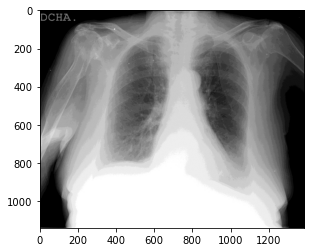

In [44]:
plt.imshow(img / img.max())